# CNTK 206 パート C: CIFAR データを用いたWassersteinと損失感受性 GAN

**前提条件**: チュートリアル CNTK 201A を完了して、CIFAR データを正常にダウンロードしたことを前提としています。または、CNTK 201A 画像データダウンローダのノートブックを実行して、CIFAR データセットをダウンロードして準備することもできます。

**貢献者**: [Anqi Li](https://www.linkedin.com/in/anqi-li-4a02b1103/)2017年10月17日

## 序論

深層学習コミュニティは、これまで伝統的に(半教師) と教師なし学習用の識別モデルを活用してきましたが、生成モデルが多くの注目を集めるようになりました。[生成敵対的ネットワーク (GAN)](https://arxiv.org/pdf/1406.2661v1.pdf)(2014 Goodfellow*ら*) は、コンピュータビジョンと自然言語処理における[様々なタスク](https://github.com/HKCaesar/really-awesome-gan)でのすばらしい結果のため最も人気のある生成モデルの一つです。しかし、元々のGANはひどく学習が困難でした。生成器と弁別器の学習のバランスが取れた慎重に選択されたハイパーパラメータとネットワークアーキテクチャなしには、GANは簡単に勾配消失やモード崩壊 (モデルが単一またはいくつかのサンプルしか生成することができない) に陥ってしまいます。本チュートリアルでは、勾配消失とモード崩壊の問題に対処するために提案された、いくつかの改良された GAN モデル、すなわち[Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf) (W-GAN) (2017 Arjovsky *ら*) と[損失感受性 GAN](https://arxiv.org/pdf/1701.06264.pdf) (LS-GAN) (2017 Qi) を紹介します。

## 概要

このセクションでは、Wasserstein GAN と元々のGAN (CNTK 206 A と B のチュートリアルに掲載されている) の間の主な違いを、理論的かつ実装の観点にも注目します。

### なぜ、GAN は訓練しにくいのか？

元々のGANの訓練では、弁別器と生成器の収束のバランスが非常に重要でした。片方がずっと先まで先行してしまった場合、他方は改善するために十分な勾配を得ることができません。しかし、2つのニューラルネットワークの収束のバランスをとるのは困難です。

[この論文](https://arxiv.org/pdf/1701.04862.pdf)のように、ここでは数学的な詳細について説明します。数学をスキップして、W-GAN と LS-GAN の実装の詳細を見てもよいでしょう。

[典型的な GAN](https://arxiv.org/pdf/1406.2661v1.pdf)には、2つのニューラルネットワーク、*生成器* $ G $ 、および*弁別器* $ D $が含まれます。GAN の訓練は、二人のプレーヤーのゼロサムゲームとしてモデル化されています。この弁別器 D は、サンプルが生成器 G から生成されたのではなく実際のサンプルである確率を予測するために訓練されており、生成器 G は本物らしいサンプルを生成することにより、できる限り弁別器をだますように訓練されている。GAN 学習の目的 (評価関数とも呼ばれます) は、

$$\min_G\max_D V(D,G)=\mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_z(x)}[\log(1-D(G(z)))]$$

元々の GAN の論文では、著者は、弁別器にとって最適な戦略は

$$D^*(x)=\frac{p_{data}(x)}{p_{data}(x)+p_{model}(x)}$$

であるることを証明しています。それを GAN の目的関数に入れ込むことで、実際には分別器は、2つの分布 (データとモデル) の*Jensen-Shannon*ダイバージェンス (JS ダイバージェンスまたは JSD) の推定であることがわかります。

$$L(D^*,g_\theta)=2 JSD(\mathbb{P}_{data}\|\mathbb{P}_{model}) - 2\log2$$

これは、$$\mathbb{P}_{data}= \mathbb{P}_{model}$$のときに最適な戦略であることを意味します。 しかし、分別器が過剰に訓練されている場合、JS 距離は局所的に飽和状態になることがあり、勾配消失になってしまう可能性があります。また、JSD は正の値です。

### Wasserstein GAN

この問題に対処するために、[Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf)では、確率分布の距離を測るために別の方法を提案しました。すなわち*Earth-Mover* (EM) 距離、または、 JS 乖離の代わりの*Wasserstein*距離です。著者らは、EM 距離を使用すれば、もはや慎重に生成器と弁別器の間のバランスを維持する必要がないと主張し、特に、弁別器の出力は、代わりに評論家と表現しました。EM 距離は、生成されたサンプルの画質の良い指標として機能します。2つの分布の EM 距離は、

$$W(p_{data}, p_{model})=\inf_{\gamma\in\prod(p_{data},p_{model})}\mathbb{E}_{(x,y)\sim\gamma}\left[\|x-y\|\right]$$

と定義されます。JSダイバージェンスと違い、EM 距離はどこでも連続で微分可能であるので、JSダイバージェンスよりも意味のある距離の測定方法です。著者らは、Kantorovich-Rubinsteinの二重性を使って、Wasserstein GAN の目的関数を導出しました。 

$$\min_G\max_{\|D\|_L\leq K} \mathbb{E}_{x\sim p_{data}(x)}[D(x)] - \mathbb{E}_{z\sim p_z(x)}[D(G(z))]$$

**注**: Kantorovich-Rubinsteinの二重性は、関数が Kリプシッツである必要があります。著者らは、[リプシッツ連続性](https://en.wikipedia.org/wiki/Lipschitz_continuity)を満たすために*弁別器の重みをクリッピング*することを推奨しています。

#### 実装の詳細

実装側で必要な変更はごくわずかです。数行のコードで元々の GAN をWasserstein GAN に変更することができます:

1. W-GAN 損失関数を使う
2. 弁別器の最後の層のシグモイド活性化関数を削除します。
3. 更新後の弁別器の重みをクリッピングする (例: [-0.01, 0.01])
4. 生成器よりも多くの弁別器を訓練する (例えば、各ラウンドで５回弁別器を訓練し1回のみ生成器を訓練する)
5. `momentum=0`のAdam を使う
6. 小さな学習率を使用する (例: 0.00005)

### 損失感受性 GAN

[損失感受性 GAN](https://arxiv.org/pdf/1701.06264.pdf)は勾配消失の問題に対処するために提案されました。LS-GAN は、生成器は、実際のさまざまなサンプルから、かけ離れた稚拙なサンプルのみを改善することに集中することができる損失関数で訓練されています。著者は、弁別器が過剰に訓練されている場合でも、LS-GAN によって学んだ損失関数は、ほとんどどこにも勾配消失がないことを示しています。

$$\min_D L_D = \mathbb{E}_{x\sim p_{data}(x)}[D(x)] + \lambda\mathbb{E}_{x\sim p_{data}(x), z\sim p_z(x)}\left[\left(\|x-G(z)\|_1 + D(x) - D(G(z))\right)_+\right]$$
$$\min_G L_G = \mathbb{E}_{z\sim p_z(x)}[D(G(z))]$$

#### 実装の詳細

これも実装側で必要な変更は軽微です。数行のコードで元々の GAN を 損失感受性 GAN に変更することができます:

1. LS-GAN 損失関数を使用する
2. 弁別器の最後の層のシグモイド活性化関数を削除します
3. 生成器と弁別器の両方を重み減衰で更新します
4. 各ラウンドで1回の反復で弁別器と生成器を訓練します

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

%matplotlib inline

実行モードは二つあります:

- *高速モード*: `isFast` は`True`に設定されています。これは、ノートブックのデフォルトのモードで、少ない反復回数で学習または、限られたデータで学習/テストすることを意味します。できたモデルは完全な学習によるものからはほど遠いですが、こうすることによってノートブックの機能の正しさを保証できます。

- *低速モード*: ユーザーがノートブックの内容に慣れ親しんだ後で、学習のためのさまざまなパラメータを変えたり、ノートブックをもっと長期間実行したりして深い洞察を得たくなったときに、このフラグを`False`に設定することをお勧めします。

**注**
`isFlag`が `False` に設定されている場合、ノートブックは GPU ありのマシンでも数時間から数日かかります。`num_minibatches`を小さい数値に設定することで、反復回数を減らすことができますが、その場合、生成された画像の品質は犠牲になります。

In [2]:
isFast = True

## データの読み取り

GANへの入力はランダムな数字のベクトルになります。トレーニングの終了時に、GAN は CIFAR データセットから取り出された画像を生成するように「学習」します。ここではチュートリアル CNTK 201A で準備したのと同じ CIFAR データを使用します。とりあえずは、次の関数が CIFAR データセットから画像を読み取るために使用するオブジェクトを返すことを気に留めておいてください。

In [3]:
# image dimensionalities
img_h, img_w = 32, 32
img_c = 3

In [4]:
# Determine the data path for testing
# Check for an environment variable defined in CNTK's test infrastructure
envvar = 'CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY'
def is_test(): return envvar in os.environ

if is_test():
    data_path = os.path.join(os.environ[envvar],'Image','CIFAR','v0','tutorial201')
    data_path = os.path.normpath(data_path)
else:
    data_path = os.path.join('data', 'CIFAR-10')
    
train_file = os.path.join(data_path, 'train_map.txt')

In [5]:
def create_reader(map_file, train):
    print("Reading map file:", map_file)
    
    if not os.path.exists(map_file):
        raise RuntimeError("This tutorials depends 201A tutorials, please run 201A first.")
    
    import cntk.io.transforms as xforms
    transforms = [xforms.crop(crop_type='center', side_ratio=0.8),
                  xforms.scale(width=img_w, height=img_h, channels=img_c, interpolations='linear')]
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=10)      # and second as 'label'
    )))

In [6]:
def noise_sample(num_samples):
    return np.random.uniform(
        low = -1.0,
        high = 1.0,
        size = [num_samples, g_input_dim]
    ).astype(np.float32)

## W-GAN Implementation

Note that we assume that you have already completed the DCGAN tutorial. If you need a basic recap of GAN concepts or DCGAN architecture, please visit our [DCGAN tutorial](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_206B_DCGAN.ipynb). 
### Model Configuration
We implemented the W-GAN based on [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) architecture. In this step, we define some of the architectural and training hyper-parameters for our model.
* The generator is convolutional transpose layer with $5\times5$ kernels and strides of $2$
* The input of the generator is a 100-dimensional random vector
* The output of the generator is a flattened $64\times64$ image with $3$ channels
* The discriminator is a convolutional layer with $5\times5$ kernels and strides of $2$
* The input of the discriminator is also a flattened $64\times64$ image with $3$ chann

## W-GAN 実装

DCGAN チュートリアルは既に完了していることを想定しています。GAN の概念や DCGAN アーキテクチャの基本的な復習が必要な場合は、[DCGAN チュートリアル](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_206B_DCGAN.ipynb)をご覧ください。

### モデル構成

[DCGAN](https://arxiv.org/pdf/1511.06434.pdf)アーキテクチャに基づいて、W-GAN を実装しました。このステップでは、モデルのアーキテクチャとトレーニングのいくつかのハイパーパラメータを定義します。

- 生成器は$ 5\times5 $のカーネルと$ 2 $のストライドを持つ畳み込み転置層です。
- 生成器の入力は100次元のランダムベクトルです
- 生成器の出力は平坦化された$3$チャネルの$ 64\times64 $の画像です
- 弁別器は、 $ 5\times5 $のカーネルと$ 2 $のストライドを持つ畳み込み層です
- 弁別器の入力は同様に平坦化された$ 3 $チャンネルの$ 64\times64 $の画像です

In [7]:
# architectural hyper-parameters
gkernel = dkernel = 5
gstride = dstride = 2

# Input / Output parameter of Generator and Discriminator
g_input_dim = 100
g_output_dim = d_input_dim = (img_c, img_h, img_w)

まずいくつかのヘルパー関数を準備します (ReLU付きのバッチ正規化とLeaky ReLU付きのバッチ正規化) これで生成器と弁別器を定義するのが幾分楽になります。

In [8]:
# Helper functions
def bn_with_relu(x, activation=C.relu):
    h = C.layers.BatchNormalization(map_rank=1)(x)
    return C.relu(h)

# We use param-relu function to use a leak=0.2 since CNTK implementation 
# of Leaky ReLU is fixed to 0.01
def bn_with_leaky_relu(x, leak=0.2):
    h = C.layers.BatchNormalization(map_rank=1)(x)
    r = C.param_relu(C.constant((np.ones(h.shape)*leak).astype(np.float32)), h)
    return r

def leaky_relu(x, leak=0.2):
    return C.param_relu(C.constant((np.ones(x.shape)*leak).astype(np.float32)), x)

**生成器**

DCGAN アーキテクチャに従って生成器を定義します。このジェネレーターは、入力として100次元のランダムベクトルを取り、平坦化された$ 3\times64\times64 $の画像を出力します。区間$ [-1, 1] $に出力を正規化するために最後の層で使うtanhを除いて、ReLU活性化関数付きのバッチ正規化を用いた畳み込み転置層を使用しています。

In [9]:
def convolutional_generator(z):
    with C.layers.default_options(init=C.normal(scale=0.02)):
        
        gfc_dim = 256
        gf_dim = 64
        
        print('Generator input shape: ', z.shape)
        
        h0 = C.layers.Dense([gfc_dim, img_h//8, img_w//8], activation=None)(z)
        h0 = bn_with_relu(h0)
        print('h0 shape', h0.shape)

        h1 = C.layers.ConvolutionTranspose2D(gkernel,
                                  num_filters=gf_dim*2,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(img_h//4, img_w//4),
                                  activation=None)(h0)
        h1 = bn_with_relu(h1)
        print('h1 shape', h1.shape)

        h2 = C.layers.ConvolutionTranspose2D(gkernel,
                                  num_filters=gf_dim,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(img_h//2, img_w//2),
                                  activation=None)(h1)
        h2 = bn_with_relu(h2)
        print('h2 shape :', h2.shape)
        
        h3 = C.layers.ConvolutionTranspose2D(gkernel,
                                  num_filters=img_c,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(img_h, img_w),
                                  activation=C.tanh)(h2)
        print('h3 shape :', h3.shape)

        return h3

**弁別器**

最後の層を除いて DCGAN アーキテクチャに従って弁別器を定義します。弁別器は、平坦化されたイメージを入力として受け取り、単一のスカラーを出力します。最後の層で活性化関数は使われていません。

In [10]:
def convolutional_discriminator(x):
    with C.layers.default_options(init=C.normal(scale=0.02)):
        
        dfc_dim = 256
        df_dim = 64
        
        print('Discriminator convolution input shape', x.shape)

        h0 = C.layers.Convolution2D(dkernel, df_dim, strides=dstride, pad=True)(x)
        h0 = leaky_relu(h0, leak=0.2)
        print('h0 shape :', h0.shape)

        h1 = C.layers.Convolution2D(dkernel, df_dim*2, strides=dstride, pad=True)(h0)
        h1 = bn_with_leaky_relu(h1, leak=0.2)
        print('h1 shape :', h1.shape)

        h2 = C.layers.Convolution2D(dkernel, dfc_dim, strides=dstride, pad=True)(h1)
        h2 = bn_with_leaky_relu(h2, leak=0.2)
        print('h2 shape :', h2.shape)

        h3 = C.layers.Dense(1, activation=None)(h2)
        print('h3 shape :', h3.shape)

        return h3

In [11]:
# training config
minibatch_size = 64
num_minibatches = 500 if isFast else 20000
lr = 0.00005 # small learning rates are preferred
momentum = 0.0 # momentum is not suggested since it can make W-GANs unstable
clip = 0.01 # the weight clipping parameter

### グラフを作成する

この弁別器は、実際の CIFAR 画像と生成関数によって生成した偽の画像の両方で使用される必要があります。計算グラフでこれを表す1つの方法は、弁別関数の入力を置き換えたうえで出力のクローンを作成することです。clone 関数で `method=share` を設定すると、弁別器モデルを通る両方のパスで同じパラメータのセットが使用されるようになります。

生成器および弁別器モデルのパラメータは異なる損失関数の勾配で個別に更新する必要があります。parameters属性を使ってグラフ内の関数のパラメータを取得することができます。ただし、モデルのパラメータを更新する場合は、他方のモデルのパラメータを変更せずに、注目するモデルのパラメータのみを更新します。つまり、生成器を更新するときには、その関数のパラメータのみを更新し、弁別関数のパラメータは固定したままにします。逆も同様です。

W-GAN は、Kリプシッツ連続性を維持するために、更新の前に毎回、弁別器の重みをクリッピングする必要があるため、`clipped_D_params`に保存されたパラメータのグラフを作成します。クリッピング閾値の推奨値は0.01 です。

**注**: CNTK のパラメーター学習器は、既定でminibatch 内の勾配の平均ではなく、勾配の合計を使用します。同じハイパーパラメータで論文の結果を再現するには、 `use_mean_gradient = True` と `unit_gain = False` を設定する必要があります。

In [ ]:
def build_WGAN_graph(noise_shape, image_shape, generator, discriminator):
    
    input_dynamic_axes = [C.Axis.default_batch_axis()]
    Z = C.input_variable(noise_shape, dynamic_axes=input_dynamic_axes)
    X_real = C.input_variable(image_shape, dynamic_axes=input_dynamic_axes)
    X_real_scaled = (X_real - 127.5) / 127.5

    # Create the model function for the generator and discriminator models
    X_fake = generator(Z)
    D_real = discriminator(X_real_scaled)
    D_fake = D_real.clone(
        method = 'share',
        substitutions = {X_real_scaled.output: X_fake.output}
    )
    
    clipped_D_params = [C.clip(p, -clip, clip) for p in D_real.parameters]
    
    G_loss = - D_fake
    D_loss = - D_real + D_fake

    G_learner = C.adam(
            parameters = X_fake.parameters,
            lr = C.learning_rate_schedule(lr, C.UnitType.sample),
            momentum = C.momentum_schedule(momentum),
            variance_momentum = C.momentum_schedule(0.999),
            unit_gain=False,
            use_mean_gradient=True
    )
            
    D_learner = C.adam(
            parameters = D_real.parameters,
            lr = C.learning_rate_schedule(lr, C.UnitType.sample),
            momentum = C.momentum_schedule(momentum),
            variance_momentum = C.momentum_schedule(0.999),
            unit_gain=False,
            use_mean_gradient=True
    )
    
    # Instantiate the trainers
    G_trainer = C.Trainer(X_fake,
                        (G_loss, None),
                        G_learner)
    D_trainer = C.Trainer(D_real,
                        (D_loss, None),
                        D_learner)

    return X_real, X_fake, D_real, clipped_D_params, Z, G_trainer, D_trainer

### モデルを訓練する

GAN を訓練するためのコードは、W-GAN 論文のアルゴリズム1に従順に従います。元々のGANと比較して、生成器よりも多くの回数、弁別器を訓練することに注意してください。その背後にある理由は、弁別器の出力を、EM 距離の推定として機能させるためです。近似的に EM 距離を推定できるまで、弁別を訓練しようとします。弁別器が訓練のごく初期でも十分良い推定ができることを保証するために、生成器を訓練する前に分別器を100回の反復訓練します。（これは大幅に長い時間がかかるので、高速モードで無効になっています。）

In [ ]:
def train_WGAN(reader_train, generator, discriminator):
    X_real, X_fake, D_real, clipped_D_params, Z, G_trainer, D_trainer = \
        build_WGAN_graph(g_input_dim, d_input_dim, generator, discriminator)
    # print out loss for each model for upto 25 times
    
    print_frequency_mbsize = num_minibatches // 25
    
    print("First row is Generator loss, second row is Discriminator loss")
    pp_G = C.logging.ProgressPrinter(print_frequency_mbsize)
    pp_D = C.logging.ProgressPrinter(print_frequency_mbsize)
    
    input_map = {X_real: reader_train.streams.features}

    for training_step in range(num_minibatches):
        # train the discriminator model for diter steps
        if not isFast and (training_step < 25 or training_step % 500 == 0):
            diter = 100
        else:
            diter = 5
        for d_train_step in range(diter):
            for parameter, clipped in zip(D_real.parameters, clipped_D_params):
                C.assign(parameter, clipped).eval()
            Z_data = noise_sample(minibatch_size)
            X_data = reader_train.next_minibatch(minibatch_size, input_map)
            batch_inputs = {X_real: X_data[X_real].data, Z: Z_data}
            D_trainer.train_minibatch(batch_inputs)
        
        Z_data = noise_sample(minibatch_size)
        batch_inputs = {Z: Z_data}
        G_trainer.train_minibatch(batch_inputs)
       
        pp_G.update_with_trainer(G_trainer)
        pp_D.update_with_trainer(D_trainer)

    G_trainer_loss = G_trainer.previous_minibatch_loss_average
    return Z, X_fake, G_trainer_loss

In [14]:
reader_train = create_reader(train_file, True)
G_input, G_output, G_trainer_loss = train_WGAN(reader_train,
                                          convolutional_generator,
                                          convolutional_discriminator)

Reading map file: c:\Data\CNTKTestData\Image\CIFAR\v0\tutorial201\train_map.txt
Generator input shape:  (100,)
h0 shape (256, 4, 4)
h1 shape (128, 8, 8)
h2 shape : (64, 16, 16)
h3 shape : (3, 32, 32)
Discriminator convolution input shape (3, 32, 32)
h0 shape : (64, 16, 16)
h1 shape : (128, 8, 8)
h2 shape : (256, 4, 4)
h3 shape : (1,)
First row is Generator loss, second row is Discriminator loss
 Minibatch[   1-  20]: loss = 0.134046 * 1280;
 Minibatch[   1-  20]: loss = -0.230201 * 1280;
 Minibatch[  21-  40]: loss = 0.290967 * 1280;
 Minibatch[  21-  40]: loss = -0.547906 * 1280;
 Minibatch[  41-  60]: loss = 0.340717 * 1280;
 Minibatch[  41-  60]: loss = -0.654352 * 1280;
 Minibatch[  61-  80]: loss = 0.356203 * 1280;
 Minibatch[  61-  80]: loss = -0.691419 * 1280;
 Minibatch[  81- 100]: loss = 0.359952 * 1280;
 Minibatch[  81- 100]: loss = -0.701833 * 1280;
 Minibatch[ 101- 120]: loss = 0.358435 * 1280;
 Minibatch[ 101- 120]: loss = -0.694525 * 1280;
 Minibatch[ 121- 140]: loss = 0.

In [ ]:
# Print the generator loss 
print("Training loss of the generator is: {0:.2f}".format(G_trainer_loss))

### 偽 (合成) 画像の生成 (W-GAN)

モデルを訓練したので、単に生成器にランダムノイズを渡し、出力を表示することによって偽の画像を作成することができます。以下は、ランダムなサンプルから生成されたいくつかの画像です。新しいサンプルのいくつかを取得するには、最後のセルを再実行します。

In [ ]:
def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        image = image[np.array([2,1,0]),:,:]
        image = np.rollaxis(image / 2 + 0.5, 0, 3)
        ax.imshow(image, vmin=-1.0, vmax=1.0)
        ax.axis('off')
    plt.show()

noise = noise_sample(36)
images = G_output.eval({G_input: noise})
plot_images(images, subplot_shape=[6, 6])

反復回数の数が多いほど、より現実的な画像を生成できます。

## LS-GAN 実装

LS-GAN の生成器と弁別器のアーキテクチャは W-GAN と同じであるため、W-GAN のために定義された生成器と弁別器を再利用します。W-GAN と LS-GAN の主な違いは、使用する損失関数と最適化の方法です。LS-GAN のトレーニングパラメータを再定義します。

In [ ]:
# training config
minibatch_size = 64
num_minibatches = 1000 if isFast else 20000
lr = 0.0001
momentum = 0.5
lambda_ = 0.0002 # lambda in LS-GAN loss function, controls the size of margin
weight_decay = 0.00005

### グラフを作成する

前述したように、LS-GAN と W-GAN の違いの一つは、損失関数です。`build_LSGAN_graph`では、生成器と弁別器の損失関数を定義する必要があります。もう一つの違いは、LS-GAN の重みのクリッピングをしないので、 `clipped_D_parames` はもはや必要ありません。代わりに、最適化で l2 正則化と数学的に等価な重み減衰を使用します。

In [ ]:
def build_LSGAN_graph(noise_shape, image_shape, generator, discriminator):
    
    input_dynamic_axes = [C.Axis.default_batch_axis()]
    Z = C.input_variable(noise_shape, dynamic_axes=input_dynamic_axes)
    X_real = C.input_variable(image_shape, dynamic_axes=input_dynamic_axes)
    X_real_scaled = (X_real - 127.5) / 127.5

    # Create the model function for the generator and discriminator models
    X_fake = generator(Z)
    D_real = discriminator(X_real_scaled)
    D_fake = D_real.clone(
        method = 'share',
        substitutions = {X_real_scaled.output: X_fake.output}
    )
    
    G_loss = D_fake
    D_loss = C.element_max(D_real - D_fake + lambda_ * C.reduce_sum(C.abs(X_fake - X_real_scaled)), [0.])
    
    G_learner = C.adam(
            parameters = X_fake.parameters,
            lr = C.learning_rate_schedule(lr, C.UnitType.sample),
            momentum = C.momentum_schedule(momentum),
            variance_momentum = C.momentum_schedule(0.999),
            l2_regularization_weight=weight_decay,
            unit_gain=False,
            use_mean_gradient=True
    )
            
    D_learner = C.adam(
            parameters = D_real.parameters,
            lr = C.learning_rate_schedule(lr, C.UnitType.sample),
            momentum = C.momentum_schedule(momentum),
            variance_momentum = C.momentum_schedule(0.999),
            l2_regularization_weight=0.00005,
            unit_gain=False,
            use_mean_gradient=True
        )
    
    # Instantiate the trainers
    G_trainer = C.Trainer(X_fake,
                        (G_loss, None),
                        G_learner)
    D_trainer = C.Trainer(D_real,
                        (D_loss, None),
                        D_learner)

    return X_real, X_fake, Z, G_trainer, D_trainer

### モデルを訓練する

LS-GAN モデルを訓練するには、単に各ラウンドで交互に弁別器と生成器を更新だけでできます。

In [19]:
def train_LSGAN(reader_train, generator, discriminator):
    X_real, X_fake, Z, G_trainer, D_trainer = \
        build_LSGAN_graph(g_input_dim, d_input_dim, generator, discriminator)
        
    # print out loss for each model for upto 25 times
    print_frequency_mbsize = num_minibatches // 25
    
    print("First row is Generator loss, second row is Discriminator loss")
    pp_G = C.logging.ProgressPrinter(print_frequency_mbsize)
    pp_D = C.logging.ProgressPrinter(print_frequency_mbsize)
    
    
    input_map = {X_real: reader_train.streams.features}

    for training_step in range(num_minibatches):
        # Train the discriminator and the generator alternatively
        Z_data = noise_sample(minibatch_size)
        X_data = reader_train.next_minibatch(minibatch_size, input_map)
        batch_inputs = {X_real: X_data[X_real].data, Z: Z_data}
        D_trainer.train_minibatch(batch_inputs)
        
        Z_data = noise_sample(minibatch_size)
        batch_inputs = {Z: Z_data}
        G_trainer.train_minibatch(batch_inputs)
        
        pp_G.update_with_trainer(G_trainer)
        pp_D.update_with_trainer(D_trainer)

    G_trainer_loss = G_trainer.previous_minibatch_loss_average
    return Z, X_fake, G_trainer_loss

In [20]:
reader_train = create_reader(train_file, True)
G_input, G_output, G_trainer_loss = train_LSGAN(reader_train,
                                          convolutional_generator,
                                          convolutional_discriminator)

Reading map file: c:\Data\CNTKTestData\Image\CIFAR\v0\tutorial201\train_map.txt
Generator input shape:  (100,)
h0 shape (256, 4, 4)
h1 shape (128, 8, 8)
h2 shape : (64, 16, 16)
h3 shape : (3, 32, 32)
Discriminator convolution input shape (3, 32, 32)
h0 shape : (64, 16, 16)
h1 shape : (128, 8, 8)
h2 shape : (256, 4, 4)
h3 shape : (1,)
First row is Generator loss, second row is Discriminator loss
 Minibatch[   1-  40]: loss = 0.228339 * 2560;
 Minibatch[   1-  40]: loss = 0.216397 * 2560;
 Minibatch[  41-  80]: loss = 1.178880 * 2560;
 Minibatch[  41-  80]: loss = 0.045059 * 2560;
 Minibatch[  81- 120]: loss = -0.669602 * 2560;
 Minibatch[  81- 120]: loss = 0.016506 * 2560;
 Minibatch[ 121- 160]: loss = 3.001537 * 2560;
 Minibatch[ 121- 160]: loss = 0.020488 * 2560;
 Minibatch[ 161- 200]: loss = 4.907479 * 2560;
 Minibatch[ 161- 200]: loss = 0.038785 * 2560;
 Minibatch[ 201- 240]: loss = 3.370783 * 2560;
 Minibatch[ 201- 240]: loss = 0.008379 * 2560;
 Minibatch[ 241- 280]: loss = 2.76794

In [21]:
# Print the generator loss 
print("Training loss of the generator is: {0:.2f}".format(G_trainer_loss))

Training loss of the generator is: 5.92


### 偽 (合成) 画像の生成 (LS-GAN)

LS-GAN モデルを訓練したので、単に生成器にランダムノイズを渡し、出力を表示することによって偽の画像を作成することができます。以下は、ランダムなサンプルから生成されたいくつかの画像です。新しいサンプルのいくつかを取得するには、最後のセルを再実行します。

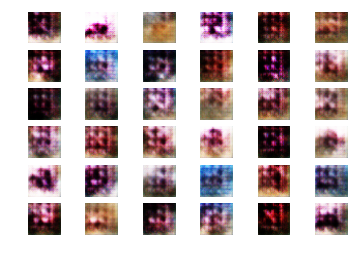

In [22]:
def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        image = image[np.array([2,1,0]),:,:]
        image = np.rollaxis(image / 2 + 0.5, 0, 3)
        ax.imshow(image, vmin=-1.0, vmax=1.0)
        ax.axis('off')
    plt.show()

noise = noise_sample(36)
images = G_output.eval({G_input: noise})
plot_images(images, subplot_shape=[6, 6])

反復回数の数が多いほど、より現実的な画像を生成できます。